# Threading a Needle through Rings Using Matplotlib

This started as a quick quiz by Ted Petrou (@TedPetrou) on Twitter. He showed the image below, and asked how to make this using Matplotlib.

![Quiz](images/thread_needle_quiz.jpg)


The sine curve is easy, the donuts (rings) are trickier, but not too difficult. But how to get the thread weaving effect?


If you want to watch the video (a GIF) that Ted Petrou made, you can find it here (Twitter) [Video](https://twitter.com/i/status/1247177426402246656)

### Solution:

The core idea: Draw the base donuts, draw the thread, and then Draw half donuts *again* on top of portions of the thread to cover them up. Since the base and the top layer are both blue, the human eye cannot tell the difference.

When Ted Petrou published his solution, he shared a figure that explains this very clearly. He uses two colors, for each halt. (Independently, when I was writing the code below, I used that same trick to debug my code.)

![half-half](images/threading_needle_2_colors.jpg)

It was a Tweet by Prof. @AllenDowney that gave me the hint I needed. I knew about Matplotlib patches, so the wedges were not too difficult. Once I got the idea of overlaying half-donuts, it was relatively easy. Here's what I quickly produced:

<img src="images/ram_original_attempt.jpg" width="650">


## Extensions
Then I figured that I could make a whole page of this, with multiple rows of rings and one long strand of thread.

<table>
<tr>
<td> <img src="images/4Rows_10Per_4rad_h5_v3.png" width="650"></td>
<td><img src="images/5Rows_20Per_4rad_h5_v3.png" width="650"></td>
</tr>
</table>


The code that follows is what I used to create these images and patterns.

I created a few "rules" for the pattern:
1. The thread always starts from the top left corner.
2. When it reaches the end of a row of rings, it turns down (south) and jumps to the next row below
3. The thread must never float completely above a donut
4. The thread is never a straight line. It is always sinusoidal, whether going horizontal or vertical
5. To complicate it just a little bit, I made the sine and cosine curves alternate in each row of rings.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

import math
from math import sin, cos

from matplotlib.patches import Arc, Ellipse

%matplotlib inline

In [69]:
def donut(center, theta1, theta2, zorder=1, ax=None, **kwargs):
    """    
    Lays down a single donut slice at the specified cx, cy location
    
    Note that it doesn't have to be a full donut. The 2 angles (theta1 and theta2) determine that
    
    center: an (x, y) tuple
    theta1, theta2 control the span of the wedge.
    0, 360 is a full circle
    90, 270 is the left semi-circle
    360, 90 is the right semi-circle
    
    """
    if ax is None:
        ax = plt.gca()

    donut_slice = Wedge((center), r=radius, theta1=theta1, theta2=theta2,
               width=radius/2, zorder=zorder, clip_on=False, **kwargs)
    ax.add_artist(donut_slice)
    #ax.plot(*center, 'k.')




def lay_down_donuts(number_per_row, position, center, radius, h_separation, theta1, theta2, zorder=1, 
                    fc='red', ax=None):
    """
    Will plot a whole row of Wedges

    Given each center cx, cy, and the theta1, theta2 
    """
    if ax is None:
        ax = plt.gca()

    startx, starty = center # center of the right-most Donut
    
    if position == 'left-only':
        d_indices = [0]
    elif position == 'right-only':
        d_indices = [number_per_row -1]
    else:
        d_indices = range(number_per_row)

    for dnum in d_indices:
        cx = startx + (h_separation + radius) * (dnum)
        cy = starty
        donut((cx,cy), theta1=theta1, theta2=theta2, zorder=zorder, fc=fc)


def h_thread(row,  total_num_rows, number_per_row, start_centerxy, 
             radius, h_sep, thread_color, dampener, sin_or_cos_flag, 
             prev_vthread_exists,
             vtxs, vtys, vtxe, vtye,                                                               
             ax=None):
    """
    Draw the sinusoidal HORIZONTAL thread from left to right, for current row being drawn
    """
    if ax is None:
        ax = plt.gca()
        

    total_odd = True if total_num_rows%2 else False
    odd_row = True if row%2 else False

    #if even_row, then entire curve will need to be 'lifted' by ys_offset
    
    startx, starty = start_centerxy    
    x_end = startx + (number_per_row-1) * (radius + h_sep)

    #Specify the x range
    x = np.arange(startx, x_end, 0.1)
    if prev_vthread_exists:
        if total_odd:
            if odd_row: #totOdd, current_odd. pin the LEFT side to vtse.
                x = np.arange(vtxe, x_end, 0.1)
            else:
                x = np.arange(startx, vtxe, 0.1)
        else:
            if odd_row: #totEven, current_odd. pin the right side to vtxe.
                x = np.arange(startx, vtxe, 0.1)
            else:
                x = np.arange(vtxe, x_end, 0.1)

    
    #y depends on x
    y = starty + np.sin(x*dampener) * sin_or_cos_flag + np.cos(x*dampener) * (1-sin_or_cos_flag)
    
    if total_odd:
        y_lift = (y[0] if odd_row else y[-1]) - starty
    else:
        y_lift = (y[-1] if odd_row else y[0]) - starty
        
    y -= y_lift
    
    ax.plot(x, y, color=thread_color, lw=5, zorder=2)
    # print(f'h_thread row:{row} ({startx}, {y[0]}) ( {x_end}, {y[-1]})')
    return(startx, y[0], x_end, y[-1]) #exact coords of horiz thread start and end


def v_thread(row,  total_num_rows, bbox,                         
             radius, h_sep, v_sep, thread_color, 
             dampener, v_dampener, 
             s_or_c, add_vconnector, 
             htxs, htys, htxe, htye,                                                               
             ax=None):
    """
    Draw vertical thread, from row N to N+1, on right or left side
    
    The side of the vertical thread depends on whether the row is odd or even.
    Note that rows are numbered from the bottom (0) to top (N)

    """
    if ax is None:
        ax = plt.gca()

    #from xs, ys to xs, ys+one row above...
    base_start_x, base_start_y, base_end_x, base_end_y = bbox
    vtxs, vtys, vtxe, vtye = 0, 0, 0, 0
    
    #Make sure that the thread always starts from the top left corner...
    #If total_num_rows is even, start at xend, if odd, start at startx
    vert_thread_right = False
    if (total_num_rows%2):
        if (row%2):
            vert_thread_right = True
    else: #even number of rows...
        if not (row%2):
            vert_thread_right = True

            
    #for TOT_ODD, ODD row...at the right end...
    #needs an x lift
    #amount = x[0]- htxe
        
    
    if add_vconnector: #the topmost row doesn't have a vert_thread
        if vert_thread_right: #start drawing from base_end_x, base_end_y
            #y didn't end exactly at ye. there is a small offset (v_offset could be +ve or -ve)
            v_offset = htye - base_start_y
            h_offset = np.sin(htys*v_dampener) * (s_or_c) + np.cos(htys*v_dampener) * (1-s_or_c)
            y = np.arange(htye, base_start_y + v_sep+(2*radius), 0.1)
            x = htxe + np.sin(y*v_dampener) * (s_or_c) + np.cos(y*v_dampener) * (1-s_or_c) - h_offset

            #Need one more h_offset, this time to account for the x at which vt starts...
            x_lift = x[0] - htxe
            x -= x_lift

            
        else:   #start drawing vertical line from LEFT. htxs and htys      
            v_offset = htye - base_start_y            
            h_offset = np.sin(htys*v_dampener) * (s_or_c) + np.cos(htys*v_dampener) * (1-s_or_c)
            y = np.arange(htys, base_start_y +v_sep+(2*radius), 0.1)
            x = base_start_x + (np.sin(y*v_dampener) * (s_or_c) + np.cos(y*v_dampener) * (1-s_or_c)) - h_offset
            
            #Need one more h_offset, this time to account for the x at which vt starts...
            x_lift = x[0] - htxs
            x -= x_lift

        ax.plot(x, y, color=thread_color, lw=5, zorder=4)

        vtxs, vtys, vtxe, vtye = x[0], y[0], x[-1], y[-1]
    
    return     vtxs, vtys, vtxe, vtye



def paint_row(row, total_num_rows, number_per_row, bbox, radius, 
              ring_color, thread_color, 
              h_sep, s_or_c,
              add_vconnector=True, 
              prev_vthread_exists=True, v_sep=0, vtxs=0, vtys=0, vtxe=0, vtye=0):
     
    
    base_start_x, base_start_y, base_end_x, base_end_y = bbox
    position = 'all'

    theta1, theta2 = 0, 360
    lay_down_donuts(number_per_row, position, (base_start_x, base_start_y), radius, h_sep, theta1, theta2, zorder=1, 
                    fc=ring_color, ax=ax)
    
    #print(f'Paint Row {rw} {vtxs} {vtxe} vtys {vtys} vtye{vtye} before calling hthread')

    htxs, htys, htxe, htye = h_thread(row,  total_num_rows, number_per_row, 
                                      (base_start_x, base_start_y), radius, h_sep, 
                                      thread_color, dampener, s_or_c, 
                                      prev_vthread_exists,
                                      vtxs, vtys, vtxe, vtye,                                                               
                                      ax=ax)
    
    left_semi = True if (row%2) else False
    right_semi = False if row%2 else True

    
    if left_semi:
        theta1, theta2 = 90, 270    
    if right_semi:
        theta1, theta2 = 270, 90
    lay_down_donuts(number_per_row, position, (base_start_x, base_start_y), radius, h_sep, theta1, theta2, 
                    zorder=3, fc=ring_color, ax=ax)
        
    #Draw vertical connectors
    vtxs, vtys, vtxe, vtye = v_thread(row,  total_num_rows, bbox, 
                                      radius, h_sep, v_sep, thread_color, 
                                      dampener, v_dampener, 
                                      s_or_c, 
                                      add_vconnector, 
                                      htxs, htys, htxe, htye,                                      
                                      ax=ax)
    
    #Draw Top and Bottom donuts. Only when current row is even
    if total_num_rows %2: #total is odd
        theta1, theta2 = 220, 340 # bottom semi
    else:
        theta1, theta2 = 55, 130    #top semi donut
        
    if row%2: #current even row (not odd)
        position = 'left-only'
    else:
        position = 'right-only'
        
    lay_down_donuts(number_per_row, position, (base_start_x, base_start_y), radius, h_sep, theta1, theta2, 
                    zorder=4, fc=ring_color, ax=ax)

    
    return(vtxs, vtys, vtxe, vtye)

        

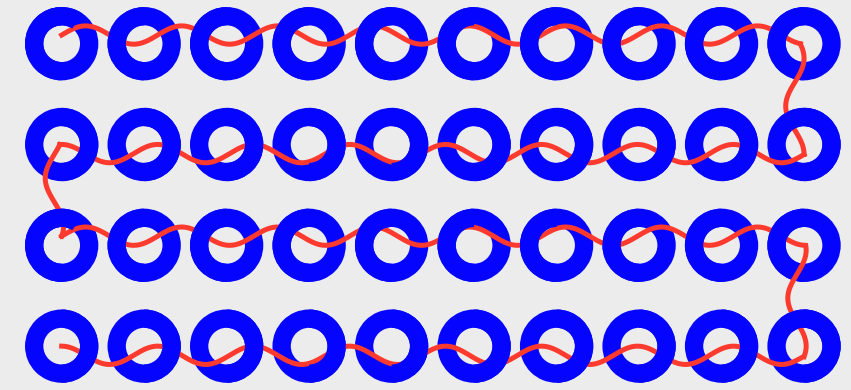

In [71]:
fig, ax = plt.subplots(figsize=(15,10))
ax.axis('off')

        
radius = 4
dia = 2 * radius
h_sep, v_sep = 5, 3
total_num_rows = 4
number_per_row = 10
dampener = 0.6
v_dampener = 0.6
ring_color = '#0505FF'
thread_color = '#FD3A2D' #darkorange'
fc_bg = '#ECECEC' #'#808080'
fig.patch.set_facecolor(fc_bg)

_filename = f'images/{total_num_rows}Rows_{number_per_row}Per_{radius}rad_h{h_sep}_v{v_sep}.png'

vtxs, vtys, vtxe, vtye = 0, 0, 0, 0
for rw in range(total_num_rows):
    add_vconnector = True
    prev_vthread_exists = False # no previous vertical thread for row 0
    if rw:
        prev_vthread_exists = True

    base_start_x, base_start_y = 0, rw * (dia +  v_sep)
    base_end_x, base_end_y = (dia+h_sep)*(number_per_row-1), (rw+1) * (dia + v_sep)

    #the bounding box for current row. Ideal startxy and endxy 
    bbox = (base_start_x, base_start_y, base_end_x, base_end_y)

    #sine or cosine flag
    s_or_c = True if (rw%2) else False
    
    #topmost row doesn't need a vertical connector on top of it
    if rw == total_num_rows-1:
        add_vconnector = False
        
    vtxs, vtys, vtxe, vtye = paint_row(rw, total_num_rows, number_per_row, bbox, radius, 
                                       ring_color, thread_color, 
                                       h_sep, s_or_c, 
                                       add_vconnector, prev_vthread_exists, v_sep, vtxs, vtys, vtxe, vtye)
    

ax.axis('scaled');

plt.savefig(_filename, facecolor = fig.get_facecolor(), transparent = True)


In [68]:
_filename

'images/4Rows_10Per_4rad_h5_v3.png'

In [33]:
import os
os.getcwd()

'C:\\Users\\ramna\\PyLibrary\\_Pyattempts\\Art_Designs_using_Python'

In [12]:
os.listdir('images')

['4Rows_10Per_4rad_h5_v3.png', '5Rows_20Per_4rad_h5_v3.png']